<a href="https://colab.research.google.com/github/JH-Y-324/first-repository/blob/master/Day07_Ch09_10_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch9 & 10 실습: 가설검정의 함정과 인과관계 추론

지난 시간, 우리는 `statsmodels`를 이용해 다양한 회귀 모델을 만드는 법을 배웠습니다. 오늘은 한 걸음 더 나아가, 통계 분석 결과를 해석할 때 빠지기 쉬운 함정들을 직접 코드로 체험하고, '상관관계'를 넘어 '인과관계'에 다가가는 고급 분석 기법들을 실습해 봅니다.

**학습 목표:**

1.  **허위 상관(Spurious Correlation)**과 **중첩요인(Confounder)**의 개념을 이해하고, 다중회귀로 중첩요인의 효과를 통제하는 법을 배웁니다.
2.  **p-해킹**과 **표본 크기의 함정**이 왜 위험한지 시뮬레이션을 통해 직접 증명합니다.
3.  실험이 불가능한 상황에서 인과 효과를 추정하는 강력한 도구, **경향 점수 짝짓기(PSM)**와 **이중차분법(DiD)**을 직접 구현해 봅니다.


## 사전 준비: 라이브러리 및 데이터 로드


In [11]:
# 필요 라이브러리 설치
!pip install statsmodels scikit-learn

# 코랩에서 한글 폰트 사용을 위한 설정 (필요 시 주석 해제 후 실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 위 코드 실행 후 상단 메뉴에서 [런타임] > [런타임 다시 시작]을 눌러주세요.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,624 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direc

In [1]:
# 런타임 다시 시작 후, 이 셀을 실행하여 라이브러리와 폰트를 로드합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.neighbors import NearestNeighbors

# 한글 폰트 설정 (Mac 사용자는 'AppleGothic', Windows 사용자는 'Malgun Gothic' 등)
try:
    plt.rc('font', family='NanumGothic')
except:
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

---


## 문제 1 (난이도: 하): 허위 상관과 중첩요인 통제하기

> **🎯 목표:** '아이스크림 판매량과 익사자 수'의 관계처럼, **허위 상관(Spurious Correlation)**이 발생하는 원인인 **중첩요인(Confounder)**을 이해하고, 다중회귀분석을 통해 그 효과를 통제하는 방법을 실습합니다.


### 💡 핵심 개념:

**허위 상관**은 두 변수 사이에 직접적인 인과관계가 없지만, '기온'과 같은 제3의 변수(중첩요인)가 두 변수 모두에 영향을 주어 마치 관계가 있는 것처럼 보이는 현상입니다. **다중회귀분석**에 중첩요인을 함께 투입하면, 다른 변수들의 영향을 고정한 상태에서의 '순수한' 관계를 파악할 수 있습니다.


### 📌 수행 과제:

1.  가상의 데이터를 생성합니다: '기온'이 높아질수록 '아이스크림 판매량'과 '해수욕객 수'가 모두 증가하는 상황을 시뮬레이션합니다.
2.  **단순회귀분석**: '아이스크림 판매량'만으로 '해수욕객 수'를 예측하는 모델을 만듭니다. 계수가 유의미하게 나오는지 확인합니다.
3.  **다중회귀분석**: '아이스크림 판매량'과 '기온'을 모두 사용하여 '해수욕객 수'를 예측하는 모델을 만듭니다.
4.  두 모델의 결과를 비교하고, '아이스크림 판매량'의 계수(coef)와 p-value가 어떻게 변했는지 해석해 보세요.


In [2]:
# 1. 가상 데이터 생성 (이 코드는 수정하지 마세요)
np.random.seed(42)
n_samples = 100
temperature = np.random.uniform(15, 35, n_samples)
ice_cream_sales = 2 * temperature + np.random.normal(0, 5, n_samples)
beach_visitors = 10 * temperature + np.random.normal(0, 20, n_samples)
df1 = pd.DataFrame({'기온': temperature, '아이스크림판매량': ice_cream_sales, '해수욕객수': beach_visitors})
print(df1.corr())

# 2. 단순회귀분석: 아이스크림판매량 -> 해수욕객수
print("\n--- 모델 1: 단순회귀분석 (아이스크림판매량 -> 해수욕객수) ---")
y = df1['해수욕객수']
# 독립변수로 '아이스크림판매량'만 선택하세요.
X_simple = df1[['아이스크림판매량']]
# X_simple에 상수항을 추가하세요.
X_simple_const = sm.add_constant(X_simple)
# OLS 모델을 y와 X_simple_const로 학습시키세요.
model_simple = sm.OLS(y, X_simple_const).fit()
print(model_simple.summary())

# 3. 다중회귀분석: (아이스크림판매량, 기온) -> 해수욕객수
print("\n--- 모델 2: 다중회귀분석 (중첩요인 '기온' 통제) ---")
# 독립변수로 '아이스크림판매량'과 '기온'을 모두 선택하세요.
X_multi = df1[['아이스크림판매량', '기온']]
# X_multi에 상수항을 추가하세요.
X_multi_const = sm.add_constant(X_multi)
# OLS 모델을 y와 X_multi_const로 학습시키세요.
model_multi = sm.OLS(y, X_multi_const).fit()
print(model_multi.summary())

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 모델 1에서 아이스크림판매량의 계수와 p-value:
# 모델 2에서 아이스크림판매량의 계수와 p-value:
# 결과가 변한 이유:

# 단순회귀분석에서는 아이스크림 판매량이 해수욕장 사람 수에 통계적으로 유의미한 +의 영향을 미치는 것처럼 보이나
# 이 분석은 중첩요인인 기온을 고려하지 않았기 때문에 해당 결과를 인과관계로 해석해서는 안된다

# 기온을 통제한 다중회귀분석에서는 아이스크림 판매량의 계수가 0에 가까운 값으로 감소하였고 p-value 역시 유의하지 않게 나타났다.
# 이는 같은 기온 조건에서는 아이스크림 판매량의 증가가 해수욕객 수에 유의미한 영향을 미치지 않음을 의미한다.

# 아이스크림 판매량과 해수욕객 수 간의 관계는 기온이라는 중첩요인에 의해 발생한 허위 상관이었기 때문이다.
# 기온을 통제하자 아이스크림 판매량의 독립적인 효과는 사라졌다.

                기온  아이스크림판매량     해수욕객수
기온        1.000000  0.927709  0.938317
아이스크림판매량  0.927709  1.000000  0.867599
해수욕객수     0.938317  0.867599  1.000000

--- 모델 1: 단순회귀분석 (아이스크림판매량 -> 해수욕객수) ---
                            OLS Regression Results                            
Dep. Variable:                  해수욕객수   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     298.3
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           1.70e-31
Time:                        08:02:25   Log-Likelihood:                -486.59
No. Observations:                 100   AIC:                             977.2
Df Residuals:                      98   BIC:                             982.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

### 🤔 생각해 볼 문제:

만약 '기온' 데이터를 수집하지 못했다면, 우리는 어떤 잘못된 결론에 도달할 위험이 있었을까요? 데이터 분석에서 '도메인 지식'이 왜 중요한지 이 사례를 통해 설명해 보세요.


만약 기온 데이터를 수집하지 못했다면, 아이스크림 판매량과 해수욕객 수 사이에 실제로 인과관계가 존재한다고 잘못 결론내렸을 가능성이 크다. (ㅋㅋ)

단순회귀분석에서는 두 변수 간의 관계가 통계적으로 유의미하게 나타났기 때문이다.

그러나 이는 기온이라는 중첩요인을 고려하지 못했기 때문에 발생한 허위 상관이다.

도메인 지식은 분석가로 하여금 어떤 중첩요인이 존재할 수 있는지 사전에 고민할 수 있게 만들고,

통계적 결과에 대해 비판적 사고를 시도할 수 있게 한다.

---


## 문제 2 (난이도: 하): 표본 크기의 함정과 효과 크기의 중요성

> **🎯 목표:** 표본 크기(n)가 커지면 아주 미미한 차이도 통계적으로 유의(p<0.05)하게 되는 현상을 확인하고, 이 때문에 **효과 크기(Effect Size)**를 함께 확인해야 하는 이유를 이해합니다.


### 💡 핵심 개념:

가설검정에서 p-value는 '귀무가설이 맞다고 가정할 때, 현재 데이터와 같거나 더 극단적인 결과가 나올 확률'입니다. 표본이 커질수록 아주 작은 차이도 우연으로 보기 어려워지므로 p-value는 작아집니다. **효과 크기**는 이 차이가 '실질적으로 얼마나 의미 있는 크기인가'를 나타내는 지표로, p-value의 한계를 보완해 줍니다.


### 📌 수행 과제:

1.  평균이 아주 약간 다른(예: 170cm vs 170.1cm) 두 집단을 가정합니다.
2.  **작은 표본(n=30)**을 각 집단에서 추출하여 t-검정을 수행하고 p-value를 확인합니다.
3.  **큰 표본(n=10,000)**을 각 집단에서 추출하여 t-검정을 수행하고 p-value를 확인합니다.
4.  두 경우 모두에 대해 **효과 크기(Cohen's d)**를 직접 계산하고, p-value와 효과 크기가 어떻게 다른 메시지를 주는지 비교 분석하세요.


In [3]:
# 효과 크기(Cohen's d) 계산 함수 (이 코드는 수정하지 마세요)
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

np.random.seed(123)
mu1, mu2, sigma = 170, 170.1, 5

# 2. 작은 표본(n=30)으로 검정
sample1_small = np.random.normal(mu1, sigma, 30)
sample2_small = np.random.normal(mu2, sigma, 30)

# scipy.stats.ttest_ind를 사용하여 두 작은 표본 간의 t-검정을 수행하세요.
t_stat_small, p_value_small = stats.ttest_ind(sample1_small, sample2_small)
effect_size_small = cohen_d(sample1_small, sample2_small)

print(f"--- 작은 표본 (n=30) 결과 ---")
print(f"P-value: {p_value_small:.4f}")
print(f"Effect Size (Cohen's d): {effect_size_small:.4f}\n")

# 3. 큰 표본(n=10000)으로 검정
sample1_large = np.random.normal(mu1, sigma, 10000)
sample2_large = np.random.normal(mu2, sigma, 10000)

# scipy.stats.ttest_ind를 사용하여 두 큰 표본 간의 t-검정을 수행하세요.
t_stat_large, p_value_large = stats.ttest_ind(sample1_large, sample2_large)
effect_size_large = cohen_d(sample1_large, sample2_large)

print(f"--- 큰 표본 (n=10000) 결과 ---")
print(f"P-value: {p_value_large:.4f}")
print(f"Effect Size (Cohen's d): {effect_size_large:.4f}\n")

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 표본 크기가 커지자 p-value는 어떻게 변했나요?:
# 두 경우의 효과 크기는 비슷한가요, 다른가요?:
# 이 결과는 우리에게 무엇을 알려주나요?:

# 감소했다
# 둘 다 절댓값이 매우 작아 효과 크기는 실질적으로 비슷하며 거의 0에 가깝다
# 효과 크기를 함께 고려해야한다

--- 작은 표본 (n=30) 결과 ---
P-value: 0.7100
Effect Size (Cohen's d): -0.0965

--- 큰 표본 (n=10000) 결과 ---
P-value: 0.1673
Effect Size (Cohen's d): -0.0195



### 🤔 생각해 볼 문제:

A/B 테스트에서 웹사이트 버튼 색깔을 바꿨더니, 클릭률이 0.1%p 증가했고, p-value는 0.001이었습니다. 이 결과를 보고 버튼 색깔을 바꾸는 것이 항상 옳다고 할 수 있을까요? '통계적 유의성'과 '실무적 중요성(practical significance)'의 차이에 대해 효과 크기 개념을 바탕으로 설명해 보세요.


클릭률 증가폭이 0.1%라는 게 실제로 매출에 의미 있는 변화인지, 사용자 행동에 체감되는 차이인지, 개발/디자인 비용을 감수할 만큼 큰지 실무적 중요성(practical significance)에서 봤을 때는 별도의 문제이다.

통계적으로 유의미하다는 것이 곧 실제로 바꿀 가치가 있다는 것을 뜻하진 않는다.

---


## 문제 3 (난이도: 중): p-해킹 시뮬레이션

> **🎯 목표:** '데이터를 보면서 분석을 계속할지 결정하는 행위'가 어떻게 잘못된 결론(제1종 오류)의 가능성을 높이는지, 즉 **p-해킹**의 위험성을 시뮬레이션을 통해 직접 증명합니다.


### 💡 핵심 개념:

**p-해킹**은 연구자가 의도했든 안 했든 p-value를 낮추기 위해 분석 과정을 조작하는 행위를 말합니다. 대표적인 예로, p-value가 0.05를 넘으면 표본을 더 모아서 다시 검정하는 행위가 있습니다. 원래 제1종 오류(실제 차이가 없는데, 차이가 있다고 결론 내릴 오류) 확률은 유의수준 α(보통 0.05)로 통제되어야 하지만, p-해킹은 이 확률을 α보다 훨씬 높게 만듭니다.


### 📌 수행 과제:

1.  **아무 차이가 없는** 두 집단 A, B를 가정합니다 (귀무가설이 참인 상황).
2.  'p-해커'를 시뮬레이션하는 함수를 만듭니다. 이 함수는 다음 로직을 따릅니다:
    - 먼저 각 집단에서 20명씩 표본을 추출하여 t-검정을 합니다.
    - p < 0.05이면 '유의미한 결과 발견!'을 외치고 멈춥니다.
    - p >= 0.05이면, 10명씩 표본을 추가하여 다시 t-검정을 합니다. 이 과정을 최대 5번까지 반복합니다.
3.  이 시뮬레이션을 1,000번 반복하여, 'p-해커'가 결국 '유의미한 결과'를 발견할 확률이 몇 %인지 계산합니다.
4.  계산된 확률이 왜 5%보다 훨씬 높은지 설명하세요.


In [4]:
# p-해킹 시뮬레이션 함수 (이 코드는 수정하지 마세요)
def p_hacking_simulation():
    mu, sigma = 0, 1
    sample_a, sample_b = list(np.random.normal(mu, sigma, 20)), list(np.random.normal(mu, sigma, 20))
    for i in range(5):
        t_stat, p_val = stats.ttest_ind(sample_a, sample_b)
        if p_val < 0.05:
            return True # p-해킹 성공!
        if i < 4:
            sample_a.extend(np.random.normal(mu, sigma, 10))
            sample_b.extend(np.random.normal(mu, sigma, 10))
    return False # 5번 시도 모두 실패

# 3. 시뮬레이션 1000번 실행
n_simulations = 1000
p_hacking_success_count = 0

# for문을 사용하여 시뮬레이션을 1000번 반복하세요.
for _ in range(n_simulations):
    # p_hacking_simulation() 함수를 호출하고, 결과가 True이면 (p-해킹에 성공하면)
    # p_hacking_success_count를 1 증가시키세요.
    if p_hacking_simulation():
        p_hacking_success_count += 1

type_1_error_rate = p_hacking_success_count / n_simulations
print(f"관찰된 제1종 오류율: {type_1_error_rate * 100:.2f}%")

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 제1종 오류율이 5%보다 훨씬 높게 나온 이유는?:
# 이러한 연구 방식(p-해킹)이 '재현성 위기'를 초래하는 이유는?:

관찰된 제1종 오류율: 11.50%


### 🤔 생각해 볼 문제:

p-해킹을 막기 위한 현실적인 방법 중 하나는 **'사전 등록(Preregistration)'** 입니다. 연구를 시작하기 전에 '표본 크기는 몇으로 할 것이며, 어떤 분석을 할 것이다'라고 미리 공개적으로 약속하는 것입니다. 이 방법이 위 시뮬레이션에서 보여준 p-해킹 문제를 어떻게 방지할 수 있을지 설명해 보세요.


표본 크기와 분석 방법을 미리 고정함으로써, 분석 결과를 확인한 후에 표본을 추가하거나 반복적으로 가설검정을 수행하는 p-해킹을 방지.

위 시뮬레이션에서는 p-value가 0.05 미만이 나올 때까지 표본을 늘려가며 검정을 반복하는 p-해킹을 했기 때문에 제1종 오류율이 증가하였다.

사전 등록을 통해 이런 행위가 벌어질 가능성을 차단하면 제1종 오류율을 유의수준 α 수준으로 통제할 수 있다.

---


## 문제 4 (난이도: 중): 경향 점수 짝짓기(PSM)로 인과 효과 추정하기

> **🎯 목표:** 무작위 통제 실험(RCT)이 불가능한 관찰 데이터에서, **선택 편향(Selection Bias)**을 통제하고 인과 효과를 추정하는 대표적인 방법인 **경향 점수 짝짓기(Propensity Score Matching, PSM)**를 직접 구현합니다.


### 💡 핵심 개념:

**PSM**은 '특정 처치(treatment)를 받을 경향'을 점수로 계산하여, 이 점수가 비슷한 실험군과 대조군 개체를 1:1로 짝지어주는 방법입니다. 이를 통해 처치 여부를 제외한 다른 특성(중첩요인)들이 비슷한, 즉 **'통계적 쌍둥이'** 집단을 만들 수 있습니다. 이 '짝지어진' 집단 간의 결과 차이를 비교하면, 선택 편향이 보정된 순수한 처치 효과에 더 가깝게 다가갈 수 있습니다.


### 📌 수행 과제:

1.  '새로운 온라인 강의 수강 여부'가 '기말고사 성적'에 미치는 영향을 분석하는 가상 데이터를 생성합니다. (단, '사전 성적'이 높고 '학습 의지'가 높은 학생일수록 강의를 신청할 확률이 높도록 **선택 편향**을 부여합니다.)
2.  **단순 비교**: 전체 수강생 집단과 비수강생 집단의 평균 성적을 비교합니다.
3.  **PSM 수행**:
    a. 로지스틱 회귀를 이용해 각 학생의 '강의 수강 경향 점수(propensity score)'를 계산합니다.
    b. 수강생(실험군) 한 명마다, 경향 점수가 가장 비슷한 비수강생(대조군)을 짝지어 줍니다. (`sklearn.neighbors.NearestNeighbors` 활용)
4.  **짝지어진 후 비교**: '짝지어진' 수강생 집단과 비수강생 집단의 평균 성적을 비교하고, 그 차이(ATT: Average Treatment Effect on the Treated)를 계산합니다.
5.  단순 비교 결과와 PSM 후의 결과를 비교하고, 왜 결과가 달라졌는지 해석합니다.


In [5]:
# 1. 선택 편향이 있는 데이터 생성 (이 코드는 수정하지 마세요)
np.random.seed(42)
n = 1000
pre_score = np.random.normal(60, 10, n)
motivation = np.random.uniform(0, 1, n)
propensity = 1 / (1 + np.exp(-( -5 + (pre_score-60)/5 + motivation*2)))
treatment = np.random.binomial(1, propensity, n)
true_effect = 5
final_score = pre_score + treatment * true_effect + np.random.normal(0, 5, n)
df4 = pd.DataFrame({'pre_score': pre_score, 'motivation': motivation, 'treatment': treatment, 'final_score': final_score})

# 2. 단순 비교 (Naive Effect)
naive_effect = df4[df4['treatment']==1]['final_score'].mean() - df4[df4['treatment']==0]['final_score'].mean()
print(f"단순 평균 비교 (성적 차이): {naive_effect:.2f}점\n")

# 3-a. 경향 점수 계산
X = df4[['pre_score', 'motivation']]
y = df4['treatment']
logit_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
df4['propensity_score'] = logit_model.predict(sm.add_constant(X))

# 3-b. 짝짓기 (Matching)
treated = df4[df4['treatment'] == 1]
control = df4[df4['treatment'] == 0]

# NearestNeighbors를 사용하여 control 그룹에서 treated 그룹과 가장 가까운 이웃 1명을 찾도록 설정하세요.
nn = NearestNeighbors(n_neighbors=1, radius=0.5)
# control 그룹의 경향 점수로 모델을 학습시키세요.
nn.fit(control[['propensity_score']])
# treated 그룹의 경향 점수를 기반으로 가장 가까운 이웃의 인덱스를 찾으세요.
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_control = control.iloc[indices.flatten()]

# 4. 짝지어진 후 비교 (ATT 계산)
# treated 그룹과 matched_control 그룹의 'final_score' 평균 차이를 계산하여 ATT를 구하세요.
att_effect = treated['final_score'].mean() - matched_control['final_score'].mean()
print(f"PSM 이후 평균 비교 (추정된 인과 효과): {att_effect:.2f}점\n")

# 5. 결과 해석 (아래 주석에 직접 작성해 보세요)
# 단순 비교 결과가 실제 효과(5점)보다 크게 나온 이유는?:
# PSM을 통해 이 문제를 어떻게 해결할 수 있었나요?:

# 선택 편향(selection bias)이 발생해서 (비슷한 처지의 사람끼리 비교하지 않았기 때문에)
# 사전 성적과 학습 의지가 비슷한 학생들끼리 짝지어 비교함으로써, 처치 여부를 제외한 다른 요인들의 영향을 통제할 수 있었다.
# 그 결과 강의 수강의 순수한 인과 효과에 더 가까운 성적 차이 추정이 가능했다.

단순 평균 비교 (성적 차이): 19.96점

PSM 이후 평균 비교 (추정된 인과 효과): 4.31점



### 🤔 생각해 볼 문제:

짝짓기(Matching)가 잘 되었는지 확인하는 방법 중 하나는, 짝지어진 두 집단의 중첩요인(여기서는 `pre_score`, `motivation`) 평균이 서로 비슷해졌는지 확인하는 것입니다. 이를 **'공변량 균형(Covariate Balance)'** 확인이라고 합니다. 짝짓기 전과 후의 `pre_score` 평균 차이를 각각 계산해보고, PSM이 공변량 균형을 맞추는 데 성공했는지 확인해보세요.


In [6]:
# 짝짓기 전 pre_score 평균
pre_treated_before = df4[df4['treatment'] == 1]['pre_score'].mean()
pre_control_before = df4[df4['treatment'] == 0]['pre_score'].mean()

diff_before = pre_treated_before - pre_control_before

print(f"짝짓기 전 pre_score 평균 차이: {diff_before:.2f}")


짝짓기 전 pre_score 평균 차이: 14.86


In [7]:
# 짝짓기 후 pre_score 평균
pre_treated_after = treated['pre_score'].mean()
pre_control_after = matched_control['pre_score'].mean()

diff_after = pre_treated_after - pre_control_after

print(f"짝짓기 후 pre_score 평균 차이: {diff_after:.2f}")


짝짓기 후 pre_score 평균 차이: -0.37


PSM이 공변량 균형을 잘 맞춤

"비슷한 학생끼리 비교 성공”

In [8]:
# motivation 균형 확인
mot_diff_before = (
    df4[df4['treatment']==1]['motivation'].mean()
    - df4[df4['treatment']==0]['motivation'].mean()
)

mot_diff_after = (
    treated['motivation'].mean()
    - matched_control['motivation'].mean()
)

print(f"짝짓기 전 motivation 평균 차이: {mot_diff_before:.3f}")
print(f"짝짓기 후 motivation 평균 차이: {mot_diff_after:.3f}")


짝짓기 전 motivation 평균 차이: 0.166
짝짓기 후 motivation 평균 차이: 0.038


---


## 문제 5 (난이도: 상): 이중차분법(DiD)으로 정책 효과 분석하기

> **🎯 목표:** 특정 집단에만 시행된 정책의 효과를 분석하는 대표적인 준실험 방법론, **이중차분법(Difference-in-Differences, DiD)**을 회귀분석으로 구현하고 핵심 가정을 이해합니다.


### 💡 핵심 개념:

**이중차분법(DiD)**은 정책이 시행된 **실험군(Treatment Group)**과 시행되지 않은 **통제군(Control Group)**의 **정책 시행 전후(Pre-Post)** 데이터를 모두 활용하는 강력한 인과추론 방법입니다. 핵심 아이디어는 '정책이 없었을 경우의 자연적인 시간 변화'를 통제군을 통해 추정하고, 이를 실험군의 변화에서 빼 줌으로써 정책의 순수한 효과만 발라내는 것입니다. 회귀분석에서는 `(실험군 여부) * (정책 후 여부)`의 **상호작용 항** 계수가 바로 DiD 추정치가 됩니다.


### 📌 수행 과제:

1.  '서울시'에만 '무료 공공 와이파이' 정책을 도입했을 때, 시민들의 '월 평균 데이터 사용량'에 미치는 영향을 분석하는 가상 데이터를 생성합니다. (실험군: 서울, 통제군: 부산)
2.  **시각화**: 정책 시행 전후, 두 도시의 평균 데이터 사용량 변화를 꺾은선 그래프로 그려봅니다.
3.  **DiD 회귀분석**: `데이터사용량 ~ is_서울 + is_정책후 + is_서울*is_정책후` 형태의 회귀 모델을 만듭니다.
    - `is_서울`: 서울이면 1, 부산이면 0
    - `is_정책후`: 정책 시행 후(2024년)이면 1, 시행 전(2023년)이면 0
    - `is_서울*is_정책후`: 상호작용 항
4.  회귀분석 결과표에서 상호작용 항의 계수(coef)와 p-value를 확인하고, 정책의 효과를 해석해 보세요.


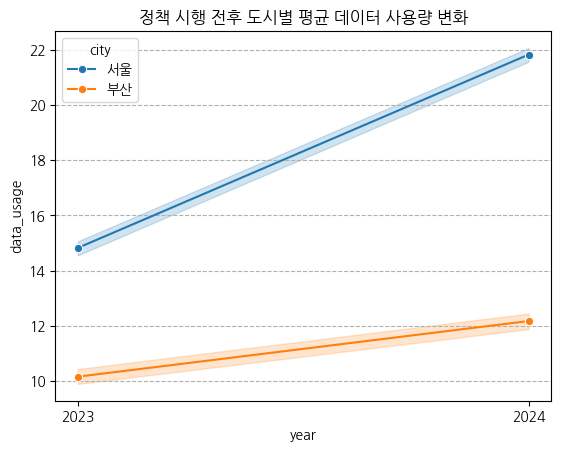

                            OLS Regression Results                            
Dep. Variable:             data_usage   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     1373.
Date:                Fri, 19 Dec 2025   Prob (F-statistic):               0.00
Time:                        08:02:46   Log-Likelihood:                -5079.1
No. Observations:                2000   AIC:                         1.017e+04
Df Residuals:                    1996   BIC:                         1.019e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1600      0.137     74.006      0.0

In [9]:
# 1. DiD 분석을 위한 가상 패널 데이터 생성 (이 코드는 수정하지 마세요)
np.random.seed(2025)
n_per_group = 500
df_seoul_pre = pd.DataFrame({'city': '서울', 'year': 2023, 'data_usage': np.random.normal(15, 3, n_per_group)})
df_seoul_post = pd.DataFrame({'city': '서울', 'year': 2024, 'data_usage': df_seoul_pre['data_usage'] + 2 + 5 + np.random.normal(0, 1, n_per_group)})
df_busan_pre = pd.DataFrame({'city': '부산', 'year': 2023, 'data_usage': np.random.normal(10, 3, n_per_group)})
df_busan_post = pd.DataFrame({'city': '부산', 'year': 2024, 'data_usage': df_busan_pre['data_usage'] + 2 + np.random.normal(0, 1, n_per_group)})
df5 = pd.concat([df_seoul_pre, df_seoul_post, df_busan_pre, df_busan_post])

# 2. 시각화 (이 코드는 수정하지 마세요)
sns.lineplot(data=df5, x='year', y='data_usage', hue='city', marker='o', errorbar='ci')
plt.title('정책 시행 전후 도시별 평균 데이터 사용량 변화')
# plt.title('Average Data Usage by City: Before vs After Policy')
plt.xticks([2023, 2024]); plt.grid(True, axis='y', linestyle='--')
plt.show()

# 3. DiD 회귀분석을 위한 변수 생성
# 'is_seoul' 변수: city가 '서울'이면 1, 아니면 0
df5['is_seoul'] = (df5['city'] == '서울').astype(int)
# 'is_post' 변수: year가 2024이면 1, 아니면 0
df5['is_post'] = (df5['year'] == 2024).astype(int)
# 상호작용 항 'did_term': 'is_seoul'과 'is_post'의 곱
df5['did_term'] = df5['is_seoul'] * df5['is_post']

y = df5['data_usage']
# 독립변수 X에 DiD 분석에 필요한 세 변수('is_seoul', 'is_post', 'did_term')를 포함시키세요.
X = df5[['is_seoul', 'is_post', 'did_term']]
# 상수항을 추가하고 OLS 모델을 학습시키세요.
model_did = sm.OLS(y, sm.add_constant(X)).fit()
print(model_did.summary())

# 4. 결과 해석 (아래 주석에 직접 작성해 보세요)
# is_seoul 계수의 의미:
# is_post 계수의 의미:
# did_term (상호작용 항) 계수의 의미:
# 따라서, 무료 와이파이 정책의 순수한 효과는 약 몇 GB 증가라고 할 수 있나요?:

# 서울은 부산보다 월 평균 데이터 사용량이 약 4.7GB 더 많았다
# 시간 흐름에 따라 월 평균 데이터 사용량이 약 2GB 증가했다
# 정책 시행 이후 서울에서만 추가로 증가한 데이터 사용량으로, 무료 공공 와이파이 정책의 순수한 인과 효과를 나타낸다
# 약 5GB

### 🤔 생각해 볼 문제:

이중차분법이 성립하기 위한 가장 중요한 가정은 **'평행추세가정(Parallel Trends Assumption)'**입니다. 즉, '만약 정책이 없었더라면, 서울과 부산의 데이터 사용량은 계속 평행하게 증가했을 것이다'라는 가정입니다. 위 시각화 그래프에서 정책 시행 **전** 시점(2023년 이전)의 데이터가 여러 개 더 있다면, 이 가정을 어떻게 확인할 수 있을지 설명해 보세요.


증가/감소의 '방향과 기울기'가 비슷하면 된다

두 선이 서로 평행하게 움직이는지, 한쪽만 갑자기 튀거나 꺾이지는 않았는지 살펴봐야한다

정책 전부터 이미 다르다면(서울이 점점 더 빨리 증가한다던지) DiD 결과를 신뢰하기가 어렵다

정책 이전 기간 동안 두 도시의 데이터 사용량이 유사한 방향과 기울기로 변화한다면, 정책이 없었더라도 두 집단이 평행한 추세를 보였을 것이라는 가정이 타당하다고 판단할 수 있음(평행추세 가정 O)